## Experimente Solutie 

In [3]:
from PIL import Image
import numpy as np

def image_to_pixel_features(image_path):

    # Load the image
    image = Image.open(image_path).convert("RGB")
    width, height = image.size
    pixels = np.array(image)

    # Prepare the data
    samples = []

    for y in range(height):
        for x in range(width):
            r, g, b = pixels[y, x]
            samples.append([x, y, r, g, b])

    # Convert to NumPy array if needed
    samples = np.array(samples)
    return samples, width, height

In [4]:
pixels, width, height = image_to_pixel_features("../../images2/image_00000.png")

Estimated number of objects: 18


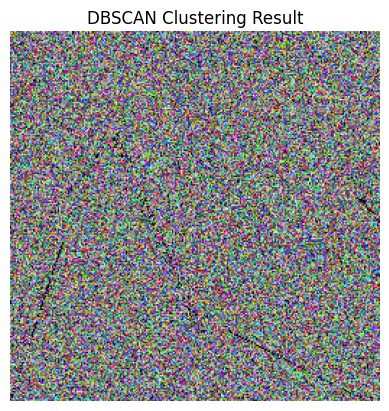

In [5]:
from PIL import Image
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(pixels)

# Apply DBSCAN
db = DBSCAN(eps=0.5, min_samples=5).fit(X_scaled)
labels = db.labels_

# Number of clusters found (excluding noise)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Estimated number of objects: {n_clusters}")

# Visualize the clustering result
# Assign each pixel the color of its cluster
label_colors = np.array([
    [np.random.randint(0, 255) for _ in range(3)] if label != -1 else [0, 0, 0]
    for label in labels
])

clustered_img = label_colors.reshape((height, width, 3)).astype(np.uint8)

# Show the clustered image
plt.imshow(clustered_img)
plt.title("DBSCAN Clustering Result")
plt.axis('off')
plt.show()

k=2 | Inertia=274378.58 | Silhouette=0.222
k=3 | Inertia=167998.19 | Silhouette=0.243
k=4 | Inertia=138200.17 | Silhouette=0.240


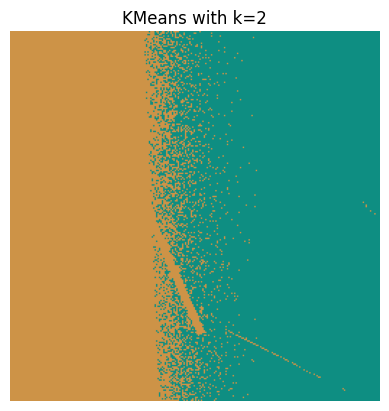

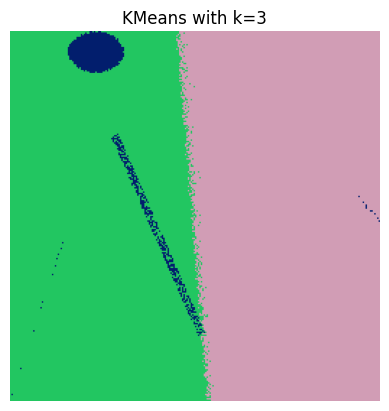

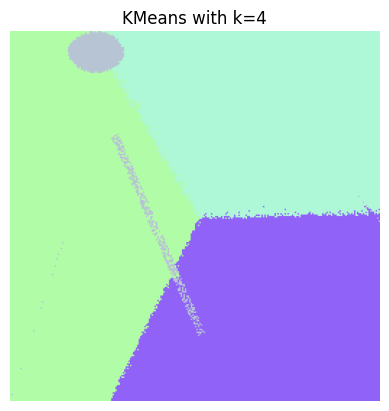

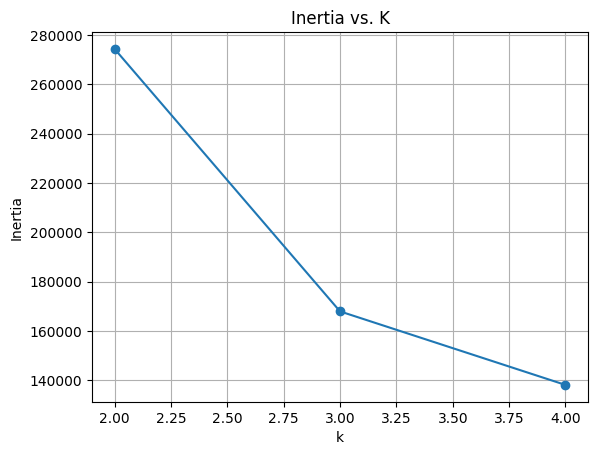

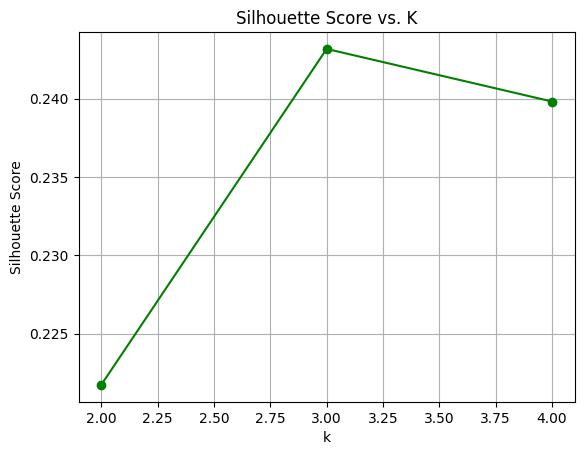

In [ ]:
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Normalize
X_scaled = StandardScaler().fit_transform(pixels)

# Setup plots
inertias = []
sil_scores = []

for k in range(2, 5):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    # Metrics
    inertia = kmeans.inertia_
    sil = silhouette_score(X_scaled, labels)
    inertias.append(inertia)
    sil_scores.append(sil)

    print(f"k={k} | Inertia={inertia:.2f} | Silhouette={sil:.3f}")

    # Color each cluster with a random color
    cluster_colors = np.array([
        [np.random.randint(0, 256) for _ in range(3)]
        for _ in range(k)
    ])
    clustered_pixels = cluster_colors[labels].reshape((height, width, 3)).astype(np.uint8)

    # Show the clustered image
    plt.figure()
    plt.imshow(clustered_pixels)
    plt.title(f"KMeans with k={k}")
    plt.axis('off')

# Plot Inertia and Silhouette Score
plt.figure()
plt.plot(range(2, 5), inertias, marker='o')
plt.title("Inertia vs. K")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.grid()

plt.figure()
plt.plot(range(2, 5), sil_scores, marker='o', color='green')
plt.title("Silhouette Score vs. K")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid()

plt.show()

## Solutie NonML

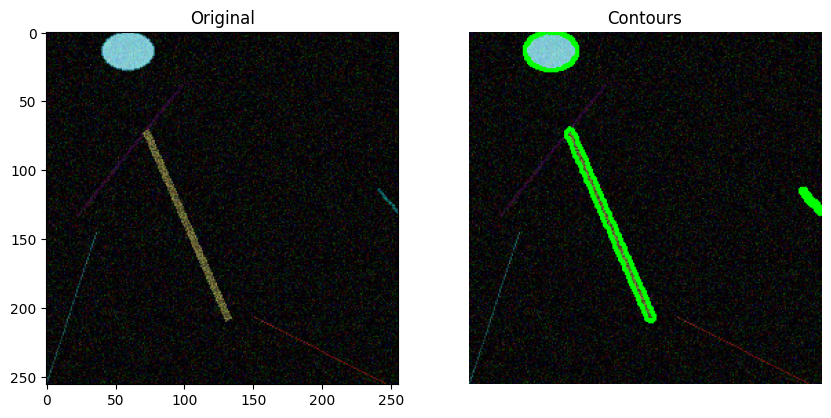

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread("../../images2/image_00000.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Optional: Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

edges = cv2.Canny(blurred, 50, 150)
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contour_img = image.copy()
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
plt.title('Contours')
plt.axis('off')
plt.show()

## Another KMeans Attempt

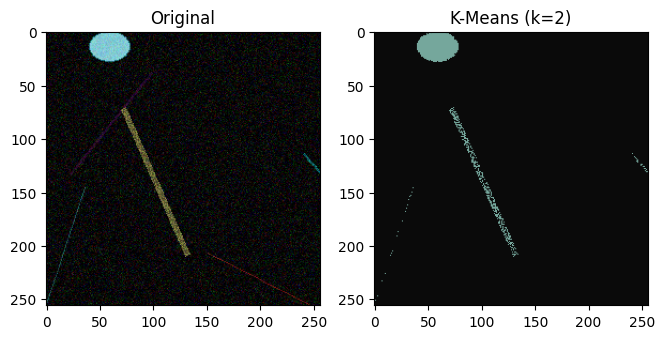

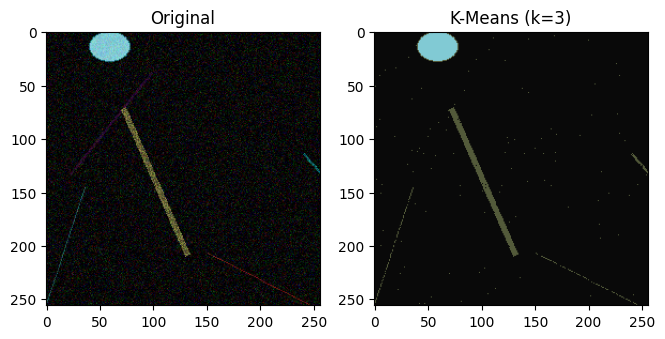

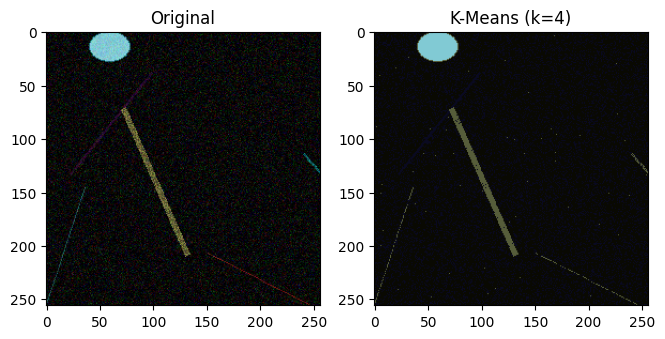

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

image = cv2.imread("../../images2/image_00000.png")
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_flat = img_rgb.reshape((-1, 3))

for k in range(2, 5):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(img_flat)
    segmented = kmeans.cluster_centers_[kmeans.labels_].reshape(image.shape).astype(np.uint8)
    
    # Show results
    plt.figure(figsize=(12,6))
    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb)
    plt.title("Original")

    plt.subplot(1, 3, 2)
    plt.imshow(segmented)
    plt.title(f"K-Means (k={k})")

## Celular Automata

Text(0.5, 1.0, 'After CA Evolution')

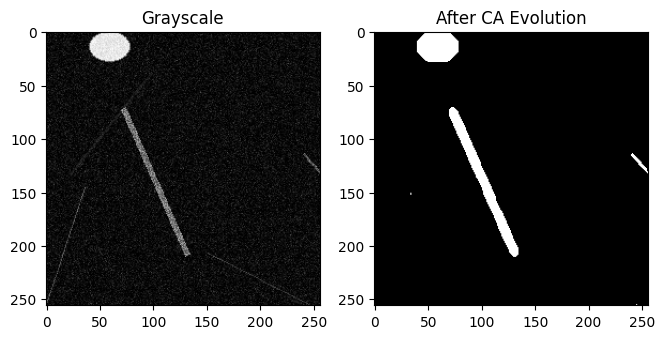

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread("../../images2/image_00000.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

_, binary = cv2.threshold(gray, 50, 1, cv2.THRESH_BINARY)

# Cellular Automaton logic
def apply_ca_step(binary_img):
    new_img = binary_img.copy()
    height, width = binary_img.shape
    for y in range(1, height-1):
        for x in range(1, width-1):
            # Count neighbors
            neighborhood = binary_img[y-1:y+2, x-1:x+2]
            count = np.sum(neighborhood) - binary_img[y, x]

            # Rule: survive if enough neighbors, else die
            if binary_img[y, x] == 1:
                if count < 2:
                    new_img[y, x] = 0
            else:
                if count >= 4:
                    new_img[y, x] = 1
    return new_img

# Step 3: Evolve CA for a few steps
ca_result = binary.copy()
for i in range(5):  # 3–10 iterations work well
    ca_result = apply_ca_step(ca_result)

# Step 6: Show results
plt.figure(figsize=(12,6))
plt.subplot(1, 3, 1)
plt.imshow(gray, cmap='gray')
plt.title("Grayscale")

plt.subplot(1, 3, 2)
plt.imshow(ca_result, cmap='gray')
plt.title("After CA Evolution")